In [1]:
# import: external libraries
import torch
import torch.optim as optim
import torchshow as ts
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from PIL import Image
from tqdm.notebook import tqdm

print(f"cuda: {torch.cuda.is_available()}")

# import: own modules
from underwater_imagery.models.suim_net.suim_net import SuimNet
from underwater_imagery.data.uim_dataset import UIMDataset
from underwater_imagery.data.constants import TRAIN_PATH, CLASSES, SHAPE
from underwater_imagery.data.transf import resize_transf, resize_normalize_transf
from underwater_imagery.models.iou_loss import SoftIoULoss
from underwater_imagery.models.metrics import logits_to_idx_class, eval
from underwater_imagery.data.transf import pred_to_label

cuda: True
(240, 320)


In [2]:
batch_size = 8

ds = UIMDataset(
    TRAIN_PATH, 
    CLASSES, 
    SHAPE,
    resize_normalize_transf,
    resize_transf
)

ds_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

In [10]:
# train the model
torch.manual_seed(123)

# Parameters
num_epochs = 120
device = 'cuda'

# create model
suim_net = SuimNet(
    classes=CLASSES,
    device=device
)

# Create Loss-Function and Optimizer
criterion = nn.CrossEntropyLoss()
iou_loss = SoftIoULoss()
optimizer = optim.Adam(suim_net.parameters())

pbar = tqdm(total=num_epochs * len(ds_loader))

step = 0
for epoch in range(0, num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(ds_loader):
        
        images, label_masks, label_images = data
        images: torch.Tensor = images.to(device)
        label_masks: torch.Tensor = label_masks.to(device)
        label_images: torch.Tensor = label_images.to(device)
        
        # Forward-Pass
        optimizer.zero_grad()
        logits = suim_net(images)
        #loss = criterion(logits, label_masks)
        loss = iou_loss(logits, label_masks)
        
        # Optimize
        loss.backward()
        optimizer.step()
        
        # Calculate Pixel-Accuracy
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=(1), keepdim=True)
        # mean pixel acc
        pixel_acc = (label_masks.argmax(dim=(1), keepdim=True) == pred).to(torch.float).mean()

        # print statistics
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_every:.3f} acc: {running_acc / print_every:.3f}'
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0
pbar.close()

print('Finished Training')
suim_path = f"suim_net_epoch{num_epochs}.pth"
torch.save(suim_net, suim_path)

  0%|          | 0/11520 [00:00<?, ?it/s]

Finished Training


In [9]:
# load trained models
suim_iou_120 = torch.load("suim_net_epoch120_iou.pth")
suim_iou_120.eval()

suim_criterion_500 = torch.load("suim_net_epoch500.pth")
suim_criterion_500.eval()
print("models loaded.")

models loaded.


image, image_label, IoU loss, cross entropy loss


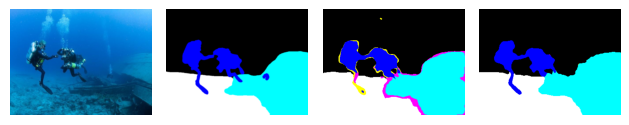

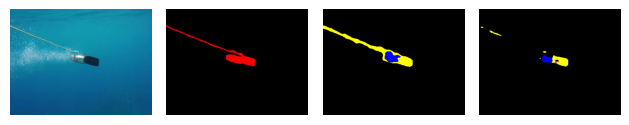

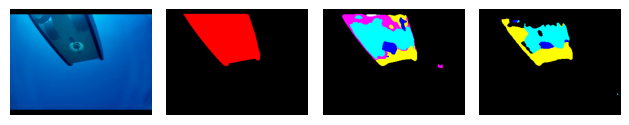

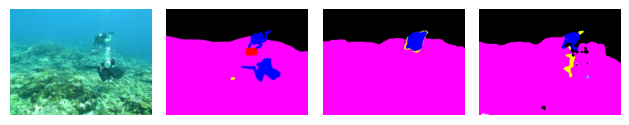

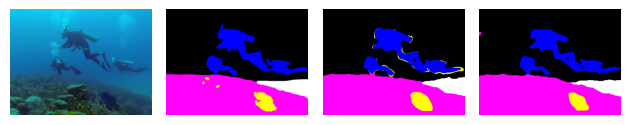

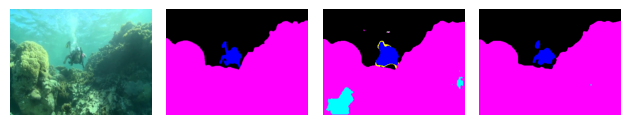

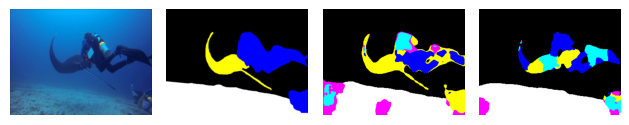

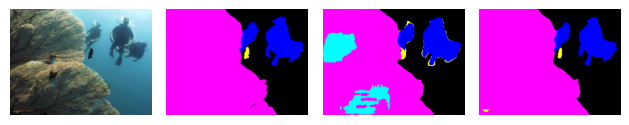

In [15]:
print("image, image_label, IoU loss, cross entropy loss")
for i in range(0, 15, 2):
    images, _, label_images = ds[i]
    images_gpu = images.unsqueeze(0).to('cuda')
    logits_iou = suim_iou_120(images_gpu)
    pred_iou = logits_to_idx_class(logits_iou)
    pred_label_iou = pred_to_label(pred_iou).squeeze(0)
    logits_criterion = suim_criterion_500(images_gpu)
    pred_criterion = logits_to_idx_class(logits_criterion)
    pred_label_criterion = pred_to_label(pred_criterion).squeeze(0)
    ts.show([images, label_images, pred_label_iou, pred_label_criterion])

IoU loss, 120 epochs
always micro
precision: 0.867
recall: 0.867
f1 score: 0.867
mean pixel acc: 0.867
soft log iou_loss: 2.750
cross entropy loss: 1.200


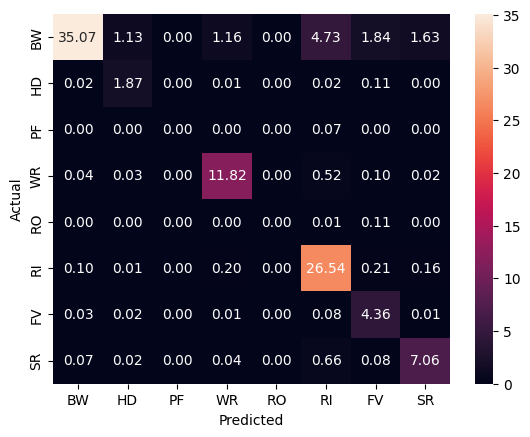

In [13]:
print("IoU loss, 120 epochs")
eval(suim_iou_120, ds_loader, device=suim_iou_120.device)

cross entropy loss, 500 epochs
always micro
precision: 0.838
recall: 0.838
f1 score: 0.838
mean pixel acc: 0.838
soft log iou_loss: 2.808
cross entropy loss: 1.117


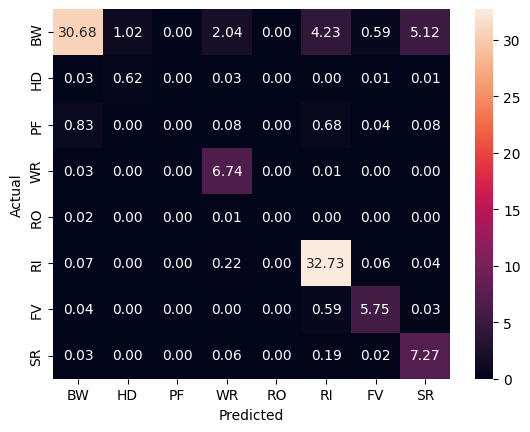

In [14]:
print("cross entropy loss, 500 epochs")
eval(suim_criterion_500, ds_loader, device=suim_criterion_500.device)